In [25]:
import  pandas as pd
import os
import sys
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from adjustText import adjust_text
from matplotlib_venn import venn2

scriptpath = "../../src/"
sys.path.append(os.path.abspath(scriptpath))
import GtfBedLibrary as gbl

In [26]:
# data
dfNaive = pd.read_csv('../../data/general/NaiveGeneIds.csv', index_col=0)
ensemblIds = dict(zip(dfNaive.gene_id, dfNaive.gene_name))

# Get transgene LFC for volcano plot
dfTransgeneWT = pd.read_csv('../Preprocessing_X_Deseq2/res_S200WT_vs_KO_deseq_lfcShrink.csv', index_col=0)
dfTransgeneWT = dfTransgeneWT.loc['LIN28A_transgene'].to_frame().T
dfTransgeneMut = pd.read_csv('../Preprocessing_X_Deseq2/res_S200A_vs_KO_deseq_lfcShrink.csv', index_col=0)
dfTransgeneMut = dfTransgeneMut.loc['LIN28A_transgene'].to_frame().T

# DESeq2
ko_wt_res_unfiltered = pd.read_csv('../../results/GeneGroups_Quantseq/KO_WT_GeneGroups_NoTPMRangeAdjustment.csv', index_col=0)
ko_wt_res = pd.read_csv('../../results/GeneGroups_Quantseq/KO_WT_GeneGroups_TPMGreaterThan5InEitherCondition_NaiveExemption_MinUtrLen100.csv', index_col=0)

ko_mut_res_unfiltered = pd.read_csv('../../results/GeneGroups_Quantseq/KO_S200A_GeneGroups_NoTPMRangeAdjustment.csv', index_col=0)

#saveto
outpath = '../../results/CharacterizationOfQuantseqGroups/'
os.makedirs(outpath, exist_ok=True)

In [27]:
colorDict = {'DOWN': "#3e6f8e", 'CONTROL': "#a8dadc", 'UP': "#e94957", 'ungrouped': "#b8b8b8"}

In [28]:
dfNaive.set_index('gene_id', drop=True, inplace=True)

In [29]:
dfNaive = dfNaive.merge(ko_wt_res, left_index=True, right_index=True, how='left')

In [30]:
dfNaive.regulation.fillna('ungrouped', inplace=True)

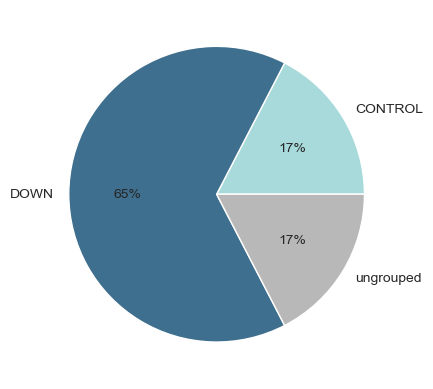

In [31]:
dfPlot = dfNaive.groupby('regulation', as_index=False)['gene_name'].count()
dfPlot['percentage'] = dfPlot['gene_name'].apply(lambda x: x * 100 / dfPlot['gene_name'].sum())
#create pie chart
labels = dfPlot.regulation.tolist()
data = dfPlot.percentage.tolist()
#define Seaborn color palette to use
colors =[colorDict[c] for c in labels]
fig, ax = plt.subplots()
g = ax.pie(data, labels = labels, colors=colors, autopct='%.0f%%',)

plt.show()
fig.savefig(f'{outpath}/NaiveInQuantseqGroups_piechart.pdf', bbox_inches='tight')

## Plot volcanoplot with marked DOWN genes and naive genes

In [32]:
ko_wt_res.regulation.fillna('unassigned', inplace=True)
ko_wt_res['hue'] = ko_wt_res.regulation.copy()
ko_wt_res.loc[[i for i in ko_wt_res.index if i in dfNaive.index], 'hue'] = 'naive'
ko_wt_res['naive_gene_name'] = dfNaive.gene_name
ko_wt_res['-log10(p_adj)'] = ko_wt_res['padj'].apply(lambda x: -np.log10(x))
ko_wt_res['-log10(p_val)'] = ko_wt_res['pvalue'].apply(lambda x: -np.log10(x))
dfTransgeneWT['-log10(p_adj)'] = dfTransgeneWT['padj'].apply(lambda x: -np.log10(x))
dfTransgeneWT['hue'] = 'LIN28A_transgene'
dfTransgeneMut['-log10(p_adj)'] = dfTransgeneMut['padj'].apply(lambda x: -np.log10(x))
dfTransgeneMut['hue'] = 'LIN28A_transgene'

In [33]:
[v for v in dfNaive.gene_name.unique() if v not in ko_wt_res.naive_gene_name.unique()]

['TFCP2']

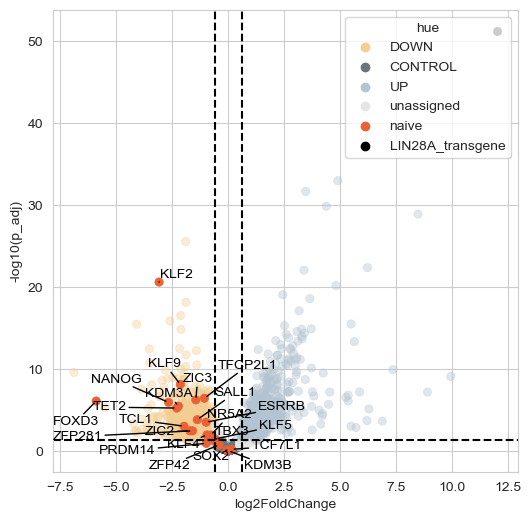

In [34]:
fig, ax = plt.subplots(figsize=(6,6))
g = sns.scatterplot(
    data=ko_wt_res.loc[ko_wt_res.hue != 'naive'], y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=.4, \
    hue_order=['DOWN', 'CONTROL', 'UP', 'unassigned'], palette=['#f3cd91', '#6c757d', '#B3C3D1', '#e5e5e5'], ax = ax, marker='o', legend=True
    )
g = sns.scatterplot(
    data=ko_wt_res.loc[ko_wt_res.hue == 'naive'], y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=1, \
    hue_order=['naive'], palette=['#eb6133'], ax=ax, marker='o', legend=True
    )
g = sns.scatterplot(
    data=dfTransgeneWT, y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=1, palette=['black'], ax=ax, marker='o'
    )



# Label naive genes
dfNaivePlot = ko_wt_res.loc[ko_wt_res.hue == 'naive']
xarr = dfNaivePlot['log2FoldChange'].values.tolist()
yarr = dfNaivePlot['-log10(p_adj)'].values.tolist()
txtarr = dfNaivePlot['naive_gene_name'].values.tolist()
texts = []
for x, y, label in zip(xarr, yarr, txtarr):
    t = ax.text(x, y, label, horizontalalignment='left', size='medium', color='black')
    texts.append(t)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

g.axhline(-np.log10(0.05), c='black', ls='dashed')
g.axvline(-np.log2(1.5), c='black', ls='dashed')
g.axvline(np.log2(1.5), c='black', ls='dashed')

sns.move_legend(ax, "upper right")

fig.savefig(f'{outpath}/Volcanoplot_labeledNaiveGenes.pdf', bbox_inches='tight')

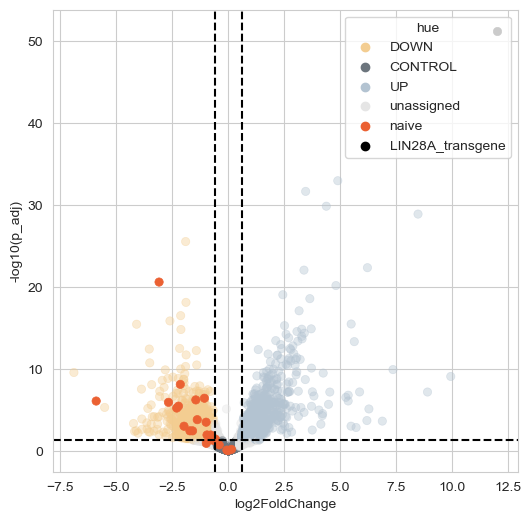

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
g = sns.scatterplot(
    data=ko_wt_res.loc[ko_wt_res.hue != 'naive'], y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=.4, \
    hue_order=['DOWN', 'CONTROL', 'UP', 'unassigned'], palette=['#f3cd91', '#6c757d', '#B3C3D1', '#e5e5e5'], ax = ax
    )
g = sns.scatterplot(
    data=ko_wt_res.loc[ko_wt_res.hue == 'naive'], y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=1, \
    hue_order=['naive'], palette=['#eb6133'], ax=ax
    )
g = sns.scatterplot(
    data=dfTransgeneWT, y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=1, palette=['black'], ax=ax, marker='o'
    )


g.axhline(-np.log10(0.05), c='black', ls='dashed')
g.axvline(-np.log2(1.5), c='black', ls='dashed')
g.axvline(np.log2(1.5), c='black', ls='dashed')

sns.move_legend(ax, "upper right")

fig.savefig(f'{outpath}/Volcanoplot_Unlabeled.pdf', bbox_inches='tight')

## Plot 2 volcanoplots side by side for KO_Mut and KO_WT and mark naive genes

/home/klara/anaconda3/envs/JupyterAnalyses/lib/python3.7/site-packages/seaborn/relational.py:943: UserWarning: relplot is a figure-level function and does not accept the `ax` parameter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


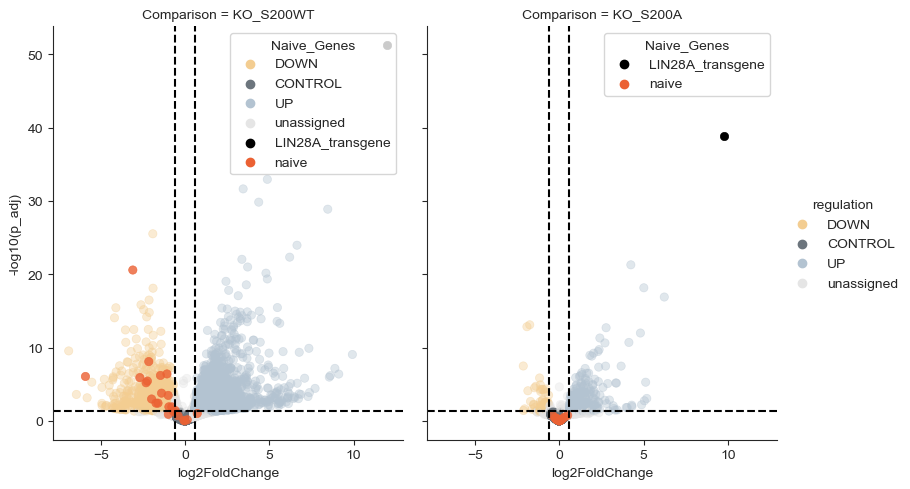

In [38]:
ko_mut_res_unfiltered['Comparison'] = 'KO_S200A'
ko_wt_res_unfiltered['Comparison'] = 'KO_S200WT'

dfPlot = pd.concat([ko_mut_res_unfiltered, ko_wt_res_unfiltered])
dfPlot.regulation.fillna('unassigned', inplace=True)
dfPlot['-log10(p_adj)'] = dfPlot.padj.apply(lambda x: -np.log10(x))
dfPlot['naive_gene_name'] = dfNaive.gene_name

sns.set_style('white')
g = sns.relplot(
    data=dfPlot.loc[dfPlot.Naive_Genes != 'naive'], y='-log10(p_adj)', x='log2FoldChange', kind='scatter', col='Comparison', edgecolor=None, alpha=.4, col_order=['KO_S200WT', 'KO_S200A'], \
    ax = ax, marker='o', color='grey',
    hue='regulation',
    hue_order=['DOWN', 'CONTROL', 'UP', 'unassigned'],
    palette=['#f3cd91', '#6c757d', '#B3C3D1', '#e5e5e5'], aspect=0.8
    )



for idx, ax in g.axes_dict.items():
    ax.axhline(-np.log10(0.05), c='black', ls='dashed')
    ax.axvline(-np.log2(1.5), c='black', ls='dashed')
    ax.axvline(np.log2(1.5), c='black', ls='dashed')
    if idx == 'KO_S200A':
        sns.scatterplot(
            data=dfTransgeneMut, y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=1, palette=['black'], ax=ax, marker='o'
        )
    elif idx == 'KO_S200WT':
        sns.scatterplot(
            data=dfTransgeneWT, y='-log10(p_adj)', x='log2FoldChange', hue='hue', edgecolor=None, alpha=1, palette=['black'], ax=ax, marker='o'
        )
    else:
        pass
    sns.scatterplot(data=dfPlot.loc[(dfPlot.Comparison == idx) & (dfPlot.Naive_Genes == 'naive')], y='-log10(p_adj)', x='log2FoldChange', hue = 'Naive_Genes', edgecolor=None, alpha=.8, \
                ax=ax, marker='o', hue_order=['naive'], palette=['#eb6133']
                )
    sns.despine(ax=ax, top=True, right=True)
    ax.tick_params(axis='both', left=True, bottom=True)

g.fig.savefig(f'{outpath}/Volcanoplots_S200A_and_S200WT.pdf', bbox_inches='tight')

In [39]:
dfPlot.loc[(dfPlot.Comparison == 'KO_S200WT') & (dfPlot.Naive_Genes == 'naive')]

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Comparison,-log10(p_adj),naive_gene_name
ENSMUSG00000067261,66.277230,-5.905145,1.336072,1.958259e-08,8.658938e-07,significant,DOWN,naive,591.0,KO_S200WT,6.062535,FOXD3
ENSMUSG00000055148,1141.878512,-3.097342,0.312138,2.128289e-24,2.635016e-21,significant,DOWN,naive,740.0,KO_S200WT,20.579217,KLF2
ENSMUSG00000012396,735.328231,-2.677617,0.526309,2.979936e-08,1.237309e-06,significant,DOWN,naive,1081.0,KO_S200WT,5.907522,NANOG
ENSMUSG00000040943,168.431893,-2.309522,0.486394,2.063869e-07,6.191151e-06,significant,DOWN,naive,3061.0,KO_S200WT,5.208229,TET2
ENSMUSG00000053470,320.392745,-2.231675,0.452734,1.100277e-07,3.638747e-06,significant,DOWN,naive,666.0,KO_S200WT,5.439048,KDM3A
ENSMUSG00000033863,1963.174020,-2.149710,0.350763,9.076863e-11,8.027130e-09,significant,DOWN,naive,3225.0,KO_S200WT,8.095440,KLF9
ENSMUSG00000041359,41.435998,-1.983542,0.645055,9.497567e-05,1.018483e-03,significant,DOWN,naive,952.0,KO_S200WT,2.992046,TCL1
ENSMUSG00000061524,54.532882,-1.720510,0.655189,4.968280e-04,3.734161e-03,significant,DOWN,naive,612.0,KO_S200WT,2.427807,ZIC2
ENSMUSG00000041483,363.648527,-1.603029,0.558564,4.995347e-04,3.752434e-03,significant,DOWN,naive,2089.0,KO_S200WT,2.425687,ZFP281
ENSMUSG00000067860,845.197633,-1.456340,0.271773,1.320896e-08,6.289958e-07,significant,DOWN,naive,2013.0,KO_S200WT,6.201352,ZIC3


### What is the overlap between downregulated genes in KO_S200A vs KO_S200WT comparison?

In [40]:
ko_wt_res_unfiltered

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Comparison
ENSMUSG00000019989,100.502042,-6.899289,1.187185,2.130376e-12,2.844469e-10,significant,DOWN,NaN,1499.0,KO_S200WT
ENSMUSG00000054727,33.385117,-6.442636,2.680247,1.643360e-05,2.451360e-04,significant,DOWN,NaN,268.0,KO_S200WT
ENSMUSG00000067261,66.277230,-5.905145,1.336072,1.958259e-08,8.658938e-07,significant,DOWN,naive,591.0,KO_S200WT
ENSMUSG00000048070,19.045768,-5.806832,2.558161,5.910746e-05,6.957515e-04,significant,DOWN,NaN,3607.0,KO_S200WT
ENSMUSG00000025056,404.741559,-5.527831,1.179622,1.667853e-07,5.209746e-06,significant,DOWN,NaN,355.0,KO_S200WT
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000024451,10.522174,8.555829,2.770623,2.460876e-08,1.057245e-06,significant,UP,NaN,547.0,KO_S200WT
ENSMUSG00000095440,10.722023,8.614497,2.737786,1.437188e-08,6.726139e-07,significant,UP,NaN,2274.0,KO_S200WT
ENSMUSG00000024526,10.917710,8.887048,2.745182,1.028770e-09,6.868046e-08,significant,UP,extended_pluripotency,265.0,KO_S200WT
ENSMUSG00000029236,11.433383,9.115209,2.849783,7.647251e-09,4.052448e-07,significant,UP,NaN,183.0,KO_S200WT


In [41]:
ko_mut_res_unfiltered

,baseMean,log2FoldChange,lfcSE,pvalue,padj,significance,regulation,Naive_Genes,UtrLength,Comparison
ENSMUSG00000050931,49.252149,-2.131909,0.346036,4.251428e-11,3.216677e-08,significant,DOWN,NaN,4125.0,KO_S200A
ENSMUSG00000032015,4.748038,-2.116996,0.980930,1.076528e-03,3.770562e-02,significant,DOWN,extended_pluripotency,1155.0,KO_S200A
ENSMUSG00000019785,4.043976,-2.052198,0.826021,5.456815e-04,2.286658e-02,significant,DOWN,NaN,976.0,KO_S200A
ENSMUSG00000051243,62.506406,-1.914760,0.238614,7.218069e-17,1.404327e-13,significant,DOWN,extended_pluripotency,1444.0,KO_S200A
ENSMUSG00000044017,23.176567,-1.858520,0.412399,3.784388e-07,7.692476e-05,significant,DOWN,extended_pluripotency,2043.0,KO_S200A
...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000021359,99.116684,5.017327,0.529723,1.536636e-22,6.975816e-19,significant,UP,NaN,1816.0,KO_S200A
ENSMUSG00000046157,15.870350,5.051244,1.402988,1.660609e-05,1.780775e-03,significant,UP,NaN,2860.0,KO_S200A
ENSMUSG00000033268,14.840990,5.125107,0.933312,1.462904e-08,5.242970e-06,significant,UP,NaN,583.0,KO_S200A
ENSMUSG00000036139,11.728618,5.191336,1.357004,7.114705e-06,8.574794e-04,significant,UP,NaN,963.0,KO_S200A


In [42]:
# Show counts of significantly UP and DOWN regulated genes
DfCountGroups = pd.DataFrame()
DfCountGroups['KO_WT'] = ko_wt_res_unfiltered.groupby('regulation').count()['baseMean']
DfCountGroups['KO_Mut'] = ko_mut_res_unfiltered.groupby('regulation').count()['baseMean']


In [43]:
DfCountGroups.reset_index(inplace=True)

In [44]:
DfCountGroups = DfCountGroups.melt(id_vars=['regulation'], var_name='DE comparison', value_name='N genes')

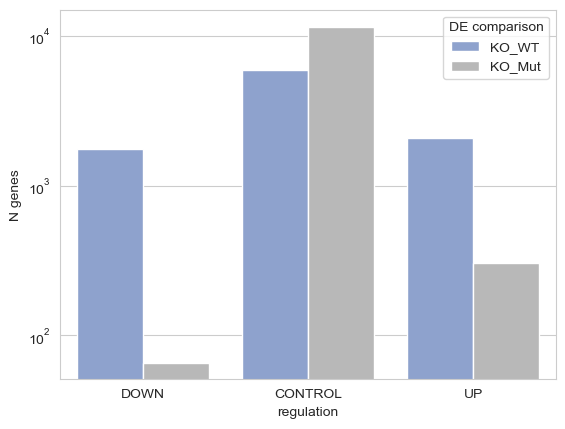

In [45]:
sns.set_style("whitegrid")
g = sns.barplot(
    data = DfCountGroups, x='regulation', y='N genes', hue='DE comparison', order=['DOWN', 'CONTROL', 'UP'],\
    hue_order=['KO_WT', 'KO_Mut'], palette=['#849ED7', '#b8b8b8']
    )
g.set_yscale('log')
g.figure.savefig(f'{outpath}/Barplot_NgenesInGroup_KO-S200A_and_KO-S200WT_comparisonDE.pdf', bbox_inches='tight')

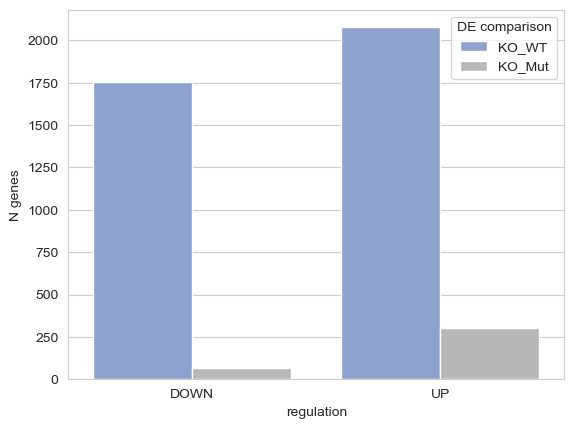

In [46]:
sns.set_style("whitegrid")
g = sns.barplot(
    data = DfCountGroups.loc[DfCountGroups.regulation.isin(['UP', 'DOWN'])], x='regulation', y='N genes',\
    hue='DE comparison', order=['DOWN', 'UP'], hue_order=['KO_WT', 'KO_Mut'], palette=['#849ED7', '#b8b8b8']
    )
# g.set_yscale('log')
g.figure.savefig(f'{outpath}/Barplot_NgenesInGroupUpDown_KO-S200A_and_KO-S200WT_comparisonDE.pdf', bbox_inches='tight')